# Global Settings

In [94]:
%pwd
GLOBALTEST = False

In [106]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time
import torch.optim as optim

from torch.utils import data

%matplotlib inline

In [88]:
cuda = torch.cuda.is_available()
if cuda: print("Using cuda!!") 
else: print("No cuda available")

No cuda available


# Loading Data

In [11]:
train_data = np.load("Data/toy_train_data.npy", allow_pickle=True)
train_label = np.load("Data/toy_train_label.npy", allow_pickle=True)
test_data = np.load("Data/toy_test_data.npy", allow_pickle=True)
test_label = np.load("Data/toy_test_label.npy", allow_pickle=True)

In [15]:
print(train_data.shape)
print(train_data[0].shape)

(1000,)
(1184, 40)


In [14]:
print(train_label.shape)
print(train_label[0].shape)

(1000,)
(1184,)


## Dataset

In [91]:
class MyDataset(data.Dataset):
    def __init__(self, data, label, context_size = 1):
        # data and label nparrays directly loaded from files
        N = len(data)
        X = []
        Y = []
        locator = []
        ctr = 0
        for i in range(N):
            xi = torch.from_numpy(data[i]).float()
            yi = torch.from_numpy(label[i]).long()
            X.append(xi)
            Y.append(yi)
            li = xi.shape[0]
            for j in range(li):
                locator.append((i, j)) #ith piece, jth time frame
                ctr += 1
        
        self.X = X
        self.Y = Y
        self.locator = locator
        self.context_size = context_size

    def __len__(self):
        return len(self.locator)

    def __getitem__(self,index):
        i, j = self.locator[index]
        left = j - self.context_size
        right = j + self.context_size # both sides inclusive
        if GLOBALTEST: print(left, right) 
        X = self.X[i][j:j+1]
        if left < 0:
            XL = self.X[i][:j]
            if GLOBALTEST: print(XL.shape) 
            XL = F.pad(input=XL, pad=(0, 0, self.context_size-XL.shape[0], 0), mode='constant', value=0)
        else:
            XL = self.X[i][left:j]
        
        if right >= self.X[i].shape[0]:
            
            XR = self.X[i][j+1:]
            XR = F.pad(input=XR, pad=(0, 0, 0, self.context_size-XR.shape[0]), mode='constant', value=0)
        else:
            XR = self.X[i][j+1:right+1]
        
        if GLOBALTEST:
            print("XL shape:", XL.shape)
            print("X shape:", X.shape)
            print("XR shape:", XR.shape)
        
        X = torch.cat((XL,X,XR), 0).reshape(-1)
        Y = self.Y[i][j]
        
        return X,Y

## Dataloader

In [98]:
num_workers = 8 if cuda else 0 

# Training
train_dataset = MyDataset(train_data, train_label)

train_loader_args = dict(shuffle=True, batch_size=256, num_workers=num_workers, pin_memory=True) if cuda\
                    else dict(shuffle=True, batch_size=64)
train_loader = data.DataLoader(train_dataset, **train_loader_args)

# Testing
test_dataset = MyDataset(test_data, test_label)

test_loader_args = dict(shuffle=False, batch_size=256, num_workers=num_workers, pin_memory=True) if cuda\
                    else dict(shuffle=False, batch_size=1)
test_loader = data.DataLoader(test_dataset, **test_loader_args)

# Model and Loss Function

In [99]:
class Simple_MLP(nn.Module):
    def __init__(self, size_list):
        super(Simple_MLP, self).__init__()
        layers = []
        self.size_list = size_list
        for i in range(len(size_list) - 2):
            layers.append(nn.Linear(size_list[i],size_list[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(size_list[-2], size_list[-1]))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [111]:
model = Simple_MLP([40*3, 256, 128, 71])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
device = torch.device("cuda" if cuda else "cpu")
model.to(device)
print(model)

Simple_MLP(
  (net): Sequential(
    (0): Linear(in_features=120, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=71, bias=True)
  )
)


# Training Procedure

In [112]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()

    running_loss = 0.0
    
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):   
        optimizer.zero_grad()   # .backward() accumulates gradients
        data = data.to(device)
        target = target.to(device) # all data & model on same device

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    end_time = time.time()
    
    running_loss /= len(train_loader)
    print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    return running_loss

In [113]:
def test_model(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0

        for batch_idx, (data, target) in enumerate(test_loader):   
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()


        running_loss /= len(test_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Testing Loss: ', running_loss)
        print('Testing Accuracy: ', acc, '%')
        return running_loss, acc

## Training

In [114]:
n_epochs = 10
save = True
Train_loss = []
Test_loss = []
Test_acc = []

for i in range(n_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    test_loss, test_acc = test_model(model, test_loader, criterion)
    Train_loss.append(train_loss)
    Test_loss.append(test_loss)
    Test_acc.append(test_acc)
    if save:
        torch.save(model.state_dict(), "checkpoint.pth")
    print('='*20)

Training Loss:  1.7692612862019592 Time:  53.129146099090576 s
Testing Loss:  1.8430810983465715
Testing Accuracy:  49.65706447187929 %
Training Loss:  1.6347281314059539 Time:  52.68295502662659 s
Testing Loss:  1.7547693066869055
Testing Accuracy:  51.09739368998628 %
Training Loss:  1.6061985282509057 Time:  53.435256004333496 s
Testing Loss:  1.6922984012724178
Testing Accuracy:  54.11522633744856 %
Training Loss:  1.5922497801840985 Time:  54.3983428478241 s
Testing Loss:  1.829222318579132
Testing Accuracy:  50.48010973936899 %
Training Loss:  1.5842128671096232 Time:  52.57500100135803 s
Testing Loss:  1.8192677649417275
Testing Accuracy:  49.72565157750343 %
Training Loss:  1.5785860865022738 Time:  52.39488172531128 s
Testing Loss:  1.8902139626319638
Testing Accuracy:  47.668038408779154 %
Training Loss:  1.5758323762224167 Time:  52.181087017059326 s
Testing Loss:  1.8416147492651722
Testing Accuracy:  49.862825788751714 %
Training Loss:  1.5738293256302192 Time:  53.4351031

## Result Visualization

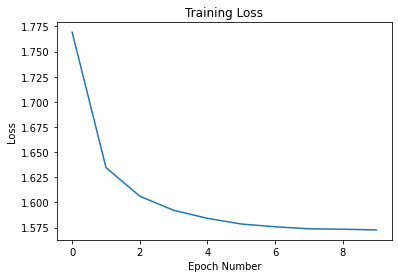

In [115]:
plt.title('Training Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(Train_loss)

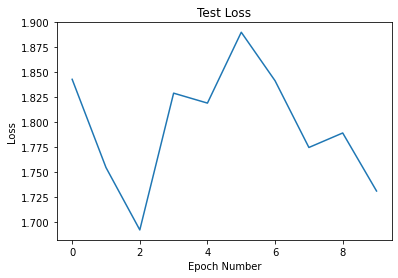

In [116]:
plt.title('Test Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(Test_loss)

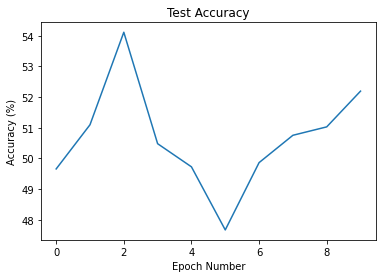

In [117]:
plt.title('Test Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.plot(Test_acc)